Используя очищенный датасет (получен и выгржен во время создания регрессионных моделей), мы поделим сообщества на сообщества в высоким и низким уровнем преступности и будем предугадывать уровень преступности.

In [1]:
import pandas as pd

C:\Users\user\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\user\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
df_crimes = pd.read_csv("crimedata_clean.csv")
df_crimes.head()

,communityName,state,countyCode,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,39.0,11980,3.10,1.37,91.78,6.50,1.88,12.47,...,14.0,114.85,138.0,1132.08,16.0,131.26,2.000000,16.410000,41.02,1394.590000
1,Marpletownship,PA,45.0,23123,2.82,0.80,95.57,3.44,0.85,11.01,...,57.0,242.37,376.0,1598.78,26.0,110.55,1.000000,4.250000,127.56,1955.950000
2,Tigardcity,OR,0.0,29344,2.43,0.74,94.33,3.43,2.35,11.36,...,274.0,758.14,1797.0,4972.19,136.0,376.30,22.000000,60.870000,218.59,6167.510000
3,Gloversvillecity,NY,35.0,16656,2.40,1.70,97.35,0.50,0.70,12.55,...,225.0,1301.78,716.0,4142.56,47.0,271.93,194.137931,35.896207,306.64,4833.412069
4,Bemidjicity,MN,7.0,11245,2.76,0.53,89.16,1.17,0.52,24.46,...,91.0,728.93,1060.0,8490.87,91.0,728.93,5.000000,40.050000,501.91,9988.790000


Нужно сделать универсальную меру измерения степени преступлений - мы не можем попросту сложить всё, т.к. кража имеет высокие показатели, а убийства - низкие, и в таком случае наша модель будет в большинстве учитывать кражи и почти не учитывать убийства (и другие преступления с низкими показателями). Потому мы проведём нормализацию данных, сложим показатели, и будем ориентироваться уже на нормализованные данные и классифицировать согласно этому показателю. Высокими будут считаться топ-30% сообществ по нормализованному кумулятивному количеству преступлений.

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

crime_columns = [
    "murders", "rapes", "robberies", "assaults",
    "burglaries", "larcenies", "autoTheft", "arsons"
]

scaler = MinMaxScaler()
df_crimes[crime_columns] = scaler.fit_transform(df_crimes[crime_columns])

df_crimes["Normalized Crime Score"] = df_crimes[crime_columns].sum(axis=1)

threshold = df_crimes["Normalized Crime Score"].quantile(0.7)

def classify_crime(score):
    if score < threshold:
        return 0
    else:
        return 1

df_crimes["High_Crime_Level"] = df_crimes["Normalized Crime Score"].apply(classify_crime)

In [4]:
df_crimes.head()

,communityName,state,countyCode,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,...,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop,Normalized Crime Score,High_Crime_Level
0,BerkeleyHeightstownship,NJ,39.0,11980,3.10,1.37,91.78,6.50,1.88,12.47,...,0.000544,1132.08,0.000133,131.26,0.000391,16.410000,41.02,1394.590000,0.001265,0
1,Marpletownship,PA,45.0,23123,2.82,0.80,95.57,3.44,0.85,11.01,...,0.001557,1598.78,0.000222,110.55,0.000195,4.250000,127.56,1955.950000,0.003324,0
2,Tigardcity,OR,0.0,29344,2.43,0.74,94.33,3.43,2.35,11.36,...,0.007600,4972.19,0.001200,376.30,0.004298,60.870000,218.59,6167.510000,0.020385,0
3,Gloversvillecity,NY,35.0,16656,2.40,1.70,97.35,0.50,0.70,12.55,...,0.003003,4142.56,0.000409,271.93,0.037925,35.896207,306.64,4833.412069,0.047775,1
4,Bemidjicity,MN,7.0,11245,2.76,0.53,89.16,1.17,0.52,24.46,...,0.004466,8490.87,0.000800,728.93,0.000977,40.050000,501.91,9988.790000,0.035241,1


## Feature engineering / генерация признаков 
Теперь мы преобразуем все классы в численные значения - таргет из низких/высоких в 0, 1, также преобразуем округ и штат используя target encoding

In [5]:
import pandas as pd

state_mapping = (
    df_crimes.groupby('state')['High_Crime_Level']
    .mean()
    .reset_index()
    .rename(columns={'High_Crime_Level': 'Mean_Target'})
)
state_mapping.to_csv("CrimeRateStateMapping.csv", index=False)

county_mapping = (
    df_crimes.groupby('countyCode')['High_Crime_Level']
    .mean()
    .reset_index()
    .rename(columns={'High_Crime_Level': 'Mean_Target'})
)
county_mapping.to_csv("CrimeRateCountyMapping.csv", index=False)

df_crimes['state_encoded'] = df_crimes['state'].map(
    state_mapping.set_index('state')['Mean_Target']
)
df_crimes['county_code_encoded'] = df_crimes['countyCode'].map(
    county_mapping.set_index('countyCode')['Mean_Target']
)

print(df_crimes.head())

             communityName state  countyCode  population  householdsize  \
0  BerkeleyHeightstownship    NJ        39.0       11980           3.10   
1           Marpletownship    PA        45.0       23123           2.82   
2               Tigardcity    OR         0.0       29344           2.43   
3         Gloversvillecity    NY        35.0       16656           2.40   
4              Bemidjicity    MN         7.0       11245           2.76   

   racepctblack  racePctWhite  racePctAsian  racePctHisp  agePct12t21  ...  \
0          1.37         91.78          6.50         1.88        12.47  ...   
1          0.80         95.57          3.44         0.85        11.01  ...   
2          0.74         94.33          3.43         2.35        11.36  ...   
3          1.70         97.35          0.50         0.70        12.55  ...   
4          0.53         89.16          1.17         0.52        24.46  ...   

   autoTheft  autoTheftPerPop    arsons  arsonsPerPop  ViolentCrimesPerPop  \
0 

Теперь наши данные готовы для обучения моделей! Проведём деление на тест и тренировочные данные

In [6]:
from sklearn.model_selection import train_test_split

cols_to_drop = [
    "murders", "murdPerPop", "rapes", "rapesPerPop", "robberies", "robbbPerPop",
    "assaults", "assaultPerPop", "burglaries", "burglPerPop", "larcenies",
    "larcPerPop", "autoTheft", "autoTheftPerPop", "arsons", "arsonsPerPop",
    "ViolentCrimesPerPop", "nonViolPerPop", "communityName", "state", 
    "countyCode", "Crime Level", "Normalized Crime Score"
]

X = df_crimes.drop(columns=cols_to_drop + ["High_Crime_Level"], errors="ignore")
y = df_crimes["High_Crime_Level"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)

print("Features (X) columns:", X_train.columns.tolist())

Train set size: (1772, 126)
Test set size: (443, 126)
Features (X) columns: ['population', 'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumKidsBornNeverMar', 'PctKidsBornNeverMar', 'NumImmig', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig', 'PctRecImmig5', 'PctRec

Выберем 20 приоритетных признаков

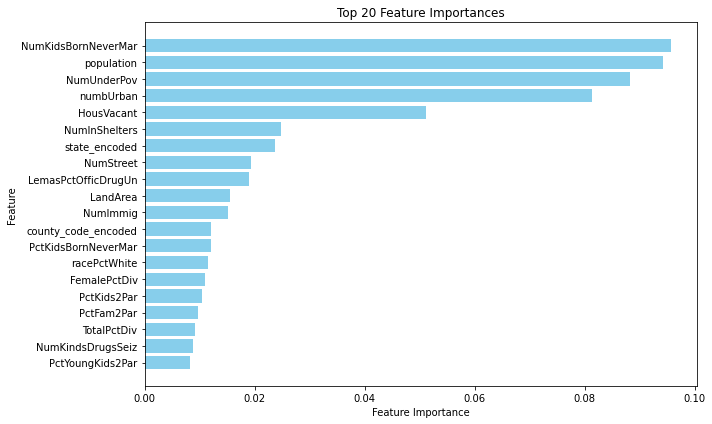

Top 20 features and chart have been saved.


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_
features = X.columns

feature_importances = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Сохраним топ-20 фичей в csv
top_20_features = feature_importances.head(20)
top_20_features.to_csv("feature_weights.csv", index=False)

# выведем график
plt.figure(figsize=(10, 6))
plt.barh(top_20_features["Feature"], top_20_features["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importances")
plt.gca().invert_yaxis()  # Invert y-axis for better visibility
plt.tight_layout()

# сохраним изображение для вывода на сайте
plt.savefig("features_chart.jpg")
plt.show()

print("Top 20 features and chart have been saved.")


Создадим функцию для тренировки модели на 20 приоритетных признаках и выгрузим модели и её показатели. Тренируем логистическую регрессию, К ближайших соседей, случайный лес и xgboost

In [9]:
import json
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

def train_and_evaluate_models(X_train_top20, X_test_top20, y_train, y_test):
    # наши модели
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "KNN Classifier": KNeighborsClassifier(n_neighbors=5),
        "Random Forest": RandomForestClassifier(random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    }
    
    
    results = []

    for name, model in models.items():
        # тренируем модель
        model.fit(X_train_top20, y_train)
        
        y_pred = model.predict(X_test_top20)
        
        # метрики для оценки перформанса модели
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # сохраняем результаты
        results.append({
            "Model": name,
            "Accuracy": acc,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1
        })
        
    results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
    results
    print("Model Comparison Results:")
    print(results_df)
    print(X_train.columns)
    # выбираем лучшую модель по рмсе 
    best_model_name = results_df.iloc[0]["Model"]
    best_model = models[best_model_name]
    best_model_results = results_df.iloc[0].to_dict()
    
    #сохраняем информацию о лучшей модели в формате Json
    with open("best_model_results.json", "w") as f:
        json.dump(best_model_results, f, indent=4)
    print("\nBest model results saved to 'best_model_results.json'")
    
    # сохраняем модель в формате пкл с использованием joblib
    joblib.dump(best_model, "best_model.pkl")
    print(f"Best model ({best_model_name}) saved to 'best_model.pkl'")
    
    return results_df, best_model

X_train_top20 = X_train[top_20_features['Feature']]
X_test_top20 = X_test[top_20_features['Feature']]

results, best_model = train_and_evaluate_models(X_train_top20, X_test_top20, y_train, y_test)

loaded_model = joblib.load("best_model.pkl")
print("\nLoaded model:", loaded_model)


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Comparison Results:
                 Model  Accuracy  Precision    Recall  F1-Score
3              XGBoost  0.918736   0.918586  0.918736  0.917589
2        Random Forest  0.911964   0.912444  0.911964  0.910210
0  Logistic Regression  0.869074   0.869815  0.869074  0.864590
1       KNN Classifier  0.860045   0.862150  0.860045  0.854022
Index(['population', 'householdsize', 'racepctblack', 'racePctWhite',
       'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29',
       'agePct16t24', 'agePct65up',
       ...
       'PopDens', 'PctUsePubTrans', 'PolicCars', 'PolicOperBudg',
       'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn',
       'PolicBudgPerPop', 'state_encoded', 'county_code_encoded'],
      dtype='object', length=126)

Best model results saved to 'best_model_results.json'
Best model (XGBoost) saved to 'best_model.pkl'

Loaded model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_

C:\Users\user\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
